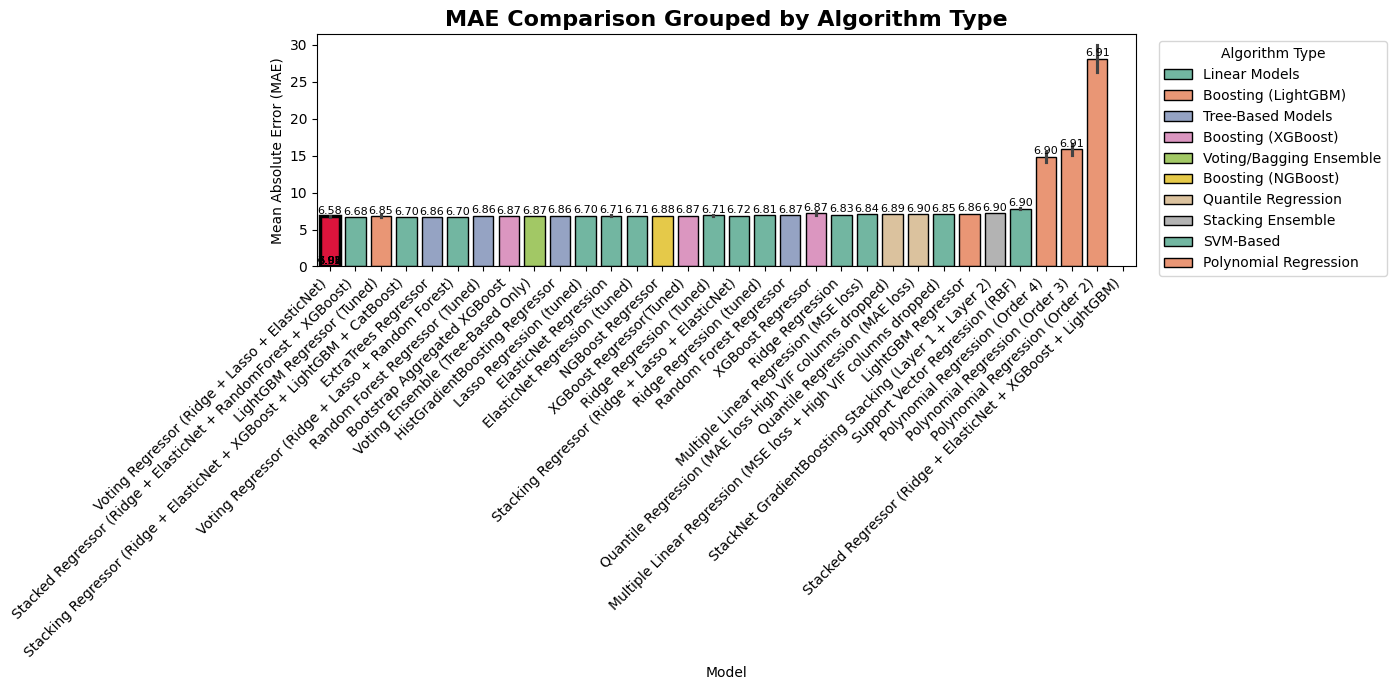

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load results
df = pd.read_csv("model_results_log.csv")

# Categorize by algorithm type
def categorize_model(name):
    name = name.lower()
    if "ridge" in name or "lasso" in name or "elastic" in name or "linear" in name:
        return "Linear Models"
    elif "random forest" in name or "extra" in name or "hist" in name:
        return "Tree-Based Models"
    elif "xgboost" in name:
        return "Boosting (XGBoost)"
    elif "lightgbm" in name:
        return "Boosting (LightGBM)"
    elif "ngboost" in name:
        return "Boosting (NGBoost)"
    elif "catboost" in name:
        return "Boosting (CatBoost)"
    elif "support vector" in name or "svr" in name:
        return "SVM-Based"
    elif "quantile" in name:
        return "Quantile Regression"
    elif "polynomial" in name:
        return "Polynomial Regression"
    elif "stack" in name:
        return "Stacking Ensemble"
    elif "voting" in name or "ensemble" in name or "bagging" in name:
        return "Voting/Bagging Ensemble"
    else:
        return "Other"

df["Algorithm Type"] = df["Model"].apply(categorize_model)

# Sort by MAE
df = df.sort_values(by="MAE", ascending=True).reset_index(drop=True)

# Identify best model
best_model_index = df["MAE"].idxmin()
df["Is Best"] = df.index == best_model_index

# Plot setup
plt.figure(figsize=(14, 7))
palette = ["gold" if is_best else "lightblue" for is_best in df["Is Best"]]

# Barplot
barplot = sns.barplot(
    x=df["Model"],
    y=df["MAE"],
    hue=df["Algorithm Type"],
    dodge=False,
    palette="Set2",
    edgecolor="black"
)

# Highlight best model with black border
bars = barplot.patches
for i, bar in enumerate(bars):
    mae = df.iloc[i]["MAE"]
    barplot.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.05,
        f"{mae:.2f}",
        ha='center',
        va='bottom',
        fontsize=8
    )
    if df.iloc[i]["Is Best"]:
        bar.set_edgecolor('black')
        bar.set_linewidth(2.5)
        bar.set_facecolor('crimson')

# Labels and title
plt.title("MAE Comparison Grouped by Algorithm Type", fontsize=16, weight='bold')
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Algorithm Type", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

# Save image
plt.savefig("model_performance/mae_comparison_by_algorithm.png", dpi=300, bbox_inches="tight")
plt.show()

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from fsd_handler import FSDModelHandler  

# Load training data
df = pd.read_csv("../train_dataset.csv")

# Separate target column
y = df["FSD Theory"]
X = df.drop(columns=["FSD Theory"])

# Predict using the handler method
preprocessor = FSDModelHandler()
preds_df = preprocessor.predict_from_model(X, model_path="fsd_model.joblib", return_type="df")

# Extract predictions
preds = preds_df["Predicted FSD Theory"].values

# Calculate MAE
mae = mean_absolute_error(y, preds)
print(f"Recalculated MAE (from saved joblib model): {mae:.4f}")


Recalculated MAE (from saved joblib model): 6.5837


In [2]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from fsd_handler import FSDModelHandler  

# Load test data
df = pd.read_csv("../test_dataset.csv")

# Separate target column
y = df["FSD Theory"]
X = df.drop(columns=["FSD Theory"])

# Predict using the handler method
preprocessor = FSDModelHandler()
preds_df = preprocessor.predict_from_model(X, model_path="fsd_model.joblib", return_type="df")

# Extract predictions
preds = preds_df["Predicted FSD Theory"].values

# Calculate MAE
mae = mean_absolute_error(y, preds)
print(preds[:5])
print(f"Recalculated MAE (from saved joblib model): {mae:.4f}")


[89.03420642 54.27696392 75.23489426 74.7845608  63.624883  ]
Recalculated MAE (from saved joblib model): 6.6572


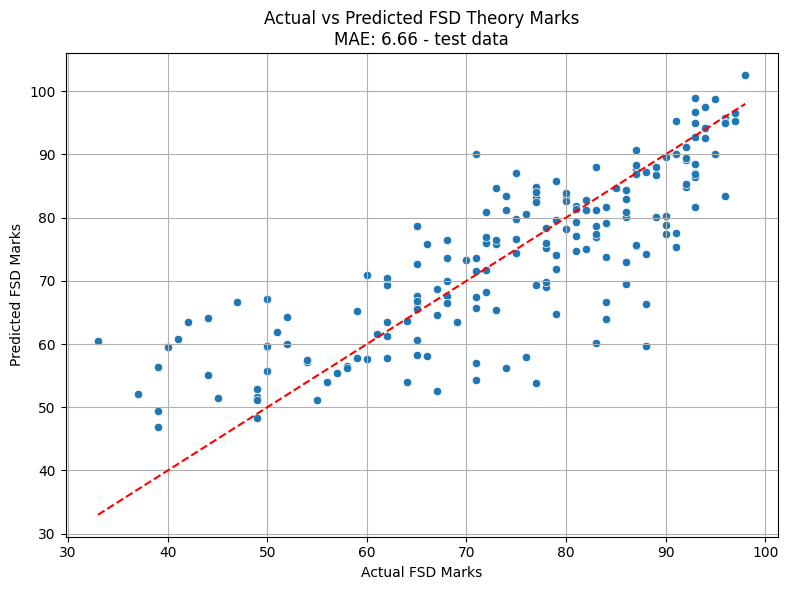

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

# Ensure directory exists
os.makedirs("model_performance", exist_ok=True)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=preds)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual FSD Marks")
plt.ylabel("Predicted FSD Marks")
plt.title(f"Actual vs Predicted FSD Theory Marks\nMAE: {mae:.2f} - test data")
plt.grid(True)
plt.tight_layout()
plt.savefig("model_performance/fsd_actual_vs_predicted.png", dpi=300)
plt.show()

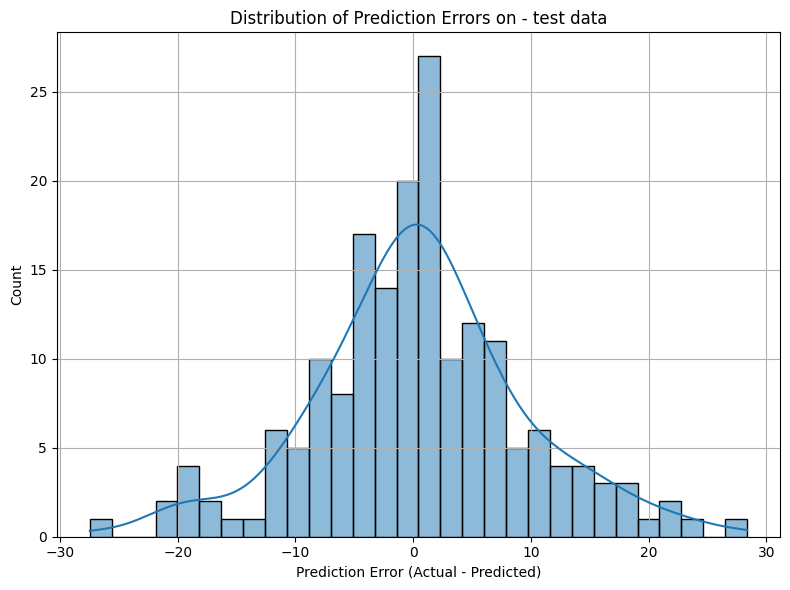

In [4]:
errors = y - preds

plt.figure(figsize=(8, 6))
sns.histplot(errors, kde=True, bins=30)
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.title("Distribution of Prediction Errors on - test data")
plt.grid(True)
plt.tight_layout()
plt.savefig("model_performance/math3_prediction_errors.png", dpi=300)
plt.show()

MAE: 6.5837


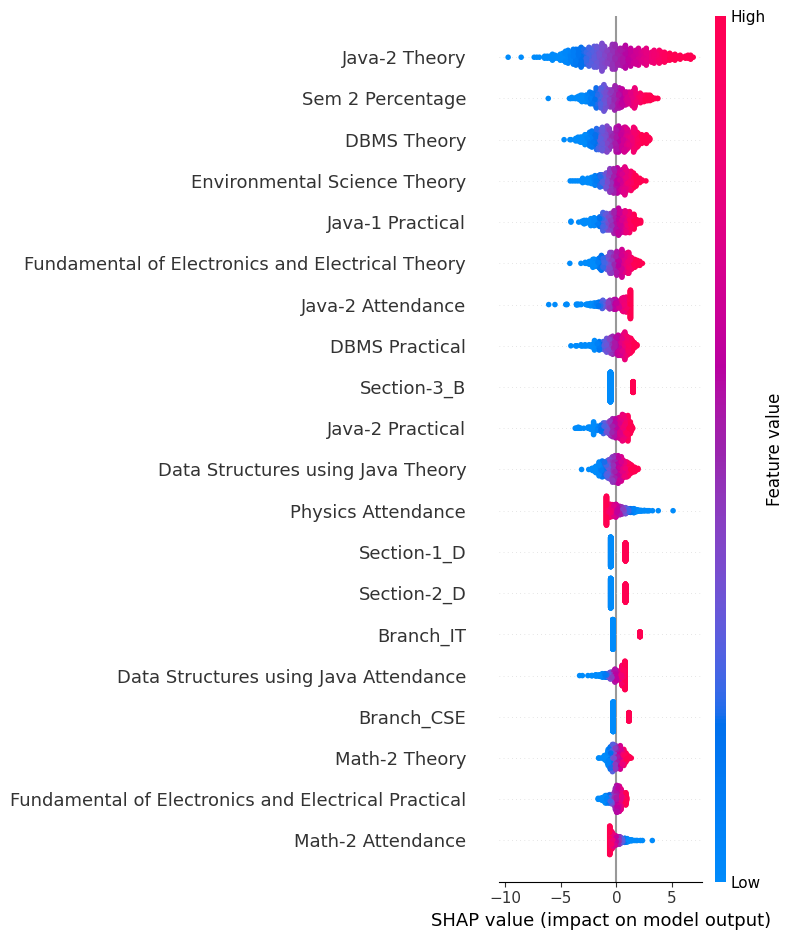

In [6]:
import pandas as pd
import numpy as np
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from skopt import BayesSearchCV

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("../train_dataset.csv")

# Drop irrelevant or data-leak columns
df = df.drop(
    columns=[
        "Student ID", "Mentor-1", "Mentor-2", "Mentor-3", "Roll-2", "Roll-3",
        "DE Theory", "DE Practical", "Math-3 Theory", "FSD Practical",
        "Python Theory", "Python Practical", "Communication Theory", "Law Theory"
    ]
)

# Feature Engineering: Semester Percentages
sem1_columns = ["Math-1 Theory", "Physics Theory", "Java-1 Theory", "Software Engineering Theory"]
sem2_columns = [
    "Math-2 Theory", "Data Structures using Java Theory", "DBMS Theory",
    "Fundamental of Electronics and Electrical Theory", "Java-2 Theory"
]
df["Sem 1 Percentage"] = df[sem1_columns].mean(axis=1).round(2)
df["Sem 2 Percentage"] = df[sem2_columns].mean(axis=1).round(2)

# Rename and clean section fields
df = df.rename(columns={"Div-1": "Section-1", "Div-2": "Section-2", "Div-3": "Section-3"})
for section in ["Section-1", "Section-2", "Section-3"]:
    df[section] = df[section].str[0]

# Define features and target
target_col = "FSD Theory"
X = df.drop(columns=[target_col])
y = df[target_col]

categorical_cols = ["Gender", "Religion", "Branch", "Section-1", "Section-2", "Section-3"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# Preprocessing
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols),
    ("num", RobustScaler(), numeric_cols),
])

# Pipelines
ridge_pipeline = Pipeline([("pre", preprocessor), ("regressor", Ridge())])
lasso_pipeline = Pipeline([("pre", preprocessor), ("regressor", Lasso(max_iter=10000))])
elastic_pipeline = Pipeline([("pre", preprocessor), ("regressor", ElasticNet(max_iter=10000))])

# Cross-validation
kf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Parameter space
param_space = {
    "ridge": {"regressor__alpha": (1e-3, 1e3, "log-uniform")},
    "lasso": {"regressor__alpha": (1e-3, 1e3, "log-uniform")},
    "elastic": {
        "regressor__alpha": (1e-3, 1e3, "log-uniform"),
        "regressor__l1_ratio": (0.05, 1.0, "uniform"),
    },
}

# Optimization
ridge_search = BayesSearchCV(ridge_pipeline, param_space["ridge"], n_iter=50, cv=kf, scoring="neg_mean_absolute_error", random_state=42)
ridge_search.fit(X, y)

lasso_search = BayesSearchCV(lasso_pipeline, param_space["lasso"], n_iter=50, cv=kf, scoring="neg_mean_absolute_error", random_state=42)
lasso_search.fit(X, y)

elastic_search = BayesSearchCV(elastic_pipeline, param_space["elastic"], n_iter=50, cv=kf, scoring="neg_mean_absolute_error", random_state=42)
elastic_search.fit(X, y)

# Ensemble
ensemble = VotingRegressor([
    ("ridge", ridge_search.best_estimator_),
    ("lasso", lasso_search.best_estimator_),
    ("elastic", elastic_search.best_estimator_),
])
ensemble.fit(X, y)

# Evaluate
ensemble_mae = np.mean(np.abs(y - ensemble.predict(X)))
print(f"MAE: {ensemble_mae:.4f}")


# Feature importance plot (average coefficients)
ridge_coef = ridge_search.best_estimator_.named_steps["regressor"].coef_
lasso_coef = lasso_search.best_estimator_.named_steps["regressor"].coef_
elastic_coef = elastic_search.best_estimator_.named_steps["regressor"].coef_
avg_coef = (ridge_coef + lasso_coef + elastic_coef) / 3

# Extract feature names after preprocessing
fitted_preprocessor = ridge_search.best_estimator_.named_steps["pre"]
cat_features = fitted_preprocessor.named_transformers_["cat"].get_feature_names_out()
num_features = numeric_cols
feature_names = np.concatenate([cat_features, num_features])


coef_df = pd.DataFrame({"Feature": feature_names, "Importance": avg_coef})
coef_df["Abs"] = coef_df["Importance"].abs()
top_features = coef_df.sort_values("Abs", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=top_features)
plt.title("Top 15 Feature Importances (Averaged Coefficients)")
plt.tight_layout()
plt.savefig("model_performance/fsd_feature_importance.png", dpi=300)
plt.close()

# SHAP Analysis (Ridge model only)
ridge_model = ridge_search.best_estimator_
X_transformed = ridge_model.named_steps["pre"].transform(X)

explainer = shap.Explainer(ridge_model.named_steps["regressor"], X_transformed)
shap_values = explainer(X_transformed)

shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig("model_performance/fsd_shap_summary.png", dpi=300)
plt.show()


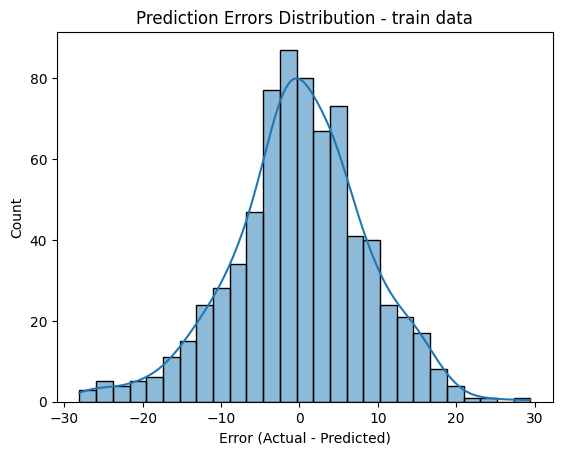

In [7]:
errors = y - ensemble.predict(X)
sns.histplot(errors, kde=True)
plt.title("Prediction Errors Distribution - train data")
plt.xlabel("Error (Actual - Predicted)")
plt.savefig("model_performance/fsd_error_distribution.png", dpi=300)
plt.show()


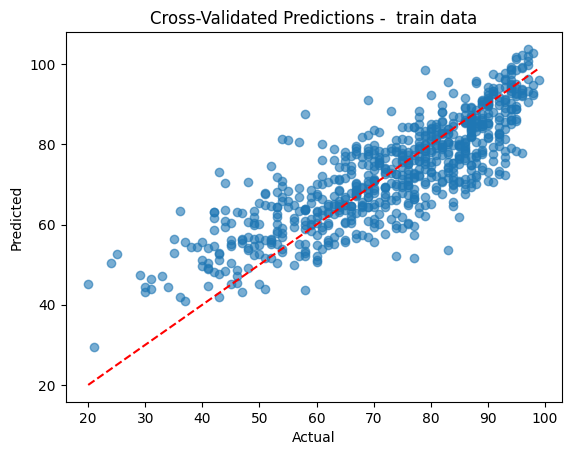

In [8]:
from sklearn.model_selection import cross_val_predict

cv_preds = cross_val_predict(ensemble, X, y)
plt.scatter(y, cv_preds, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Cross-Validated Predictions -  train data")
plt.savefig("model_performance/fsd_cv_predictions.png", dpi=300)
plt.show()


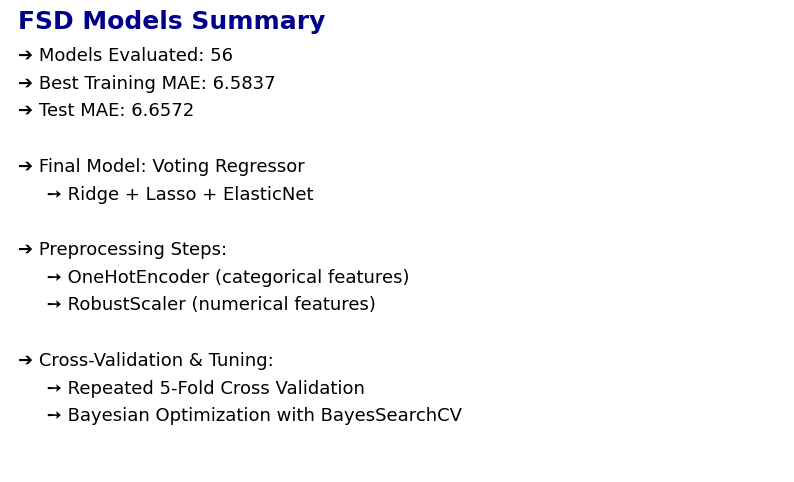

Image saved to: model_performance\optimized_ensemble_model_summary.png


In [5]:
import matplotlib.pyplot as plt
import os

# Ensure the output directory exists
os.makedirs("model_performance", exist_ok=True)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

# Title and content text
title = "FSD Models Summary"
content_lines = [
    "➔ Models Evaluated: 56",
    "➔ Best Training MAE: 6.5837",
    "➔ Test MAE: 6.6572",
    "",
    "➔ Final Model: Voting Regressor",
    "     ➙ Ridge + Lasso + ElasticNet",
    "",
    "➔ Preprocessing Steps:",
    "     ➙ OneHotEncoder (categorical features)",
    "     ➙ RobustScaler (numerical features)",
    "",
    "➔ Cross-Validation & Tuning:",
    "     ➙ Repeated 5-Fold Cross Validation",
    "     ➙ Bayesian Optimization with BayesSearchCV",
]

# Add title and content to the plot
ax.text(0.01, 1.00, title, fontsize=18, fontweight="bold", verticalalignment="top", color="darkblue")
for i, line in enumerate(content_lines):
    ax.text(0.01, 0.92 - i * 0.06, line, fontsize=13, verticalalignment="top", color="black")

# Define the output file name and path
output_file = "optimized_ensemble_model_summary.png"
output_path = os.path.join("model_performance", output_file)

# Save and display the figure
plt.savefig(output_path, bbox_inches="tight", dpi=300)
plt.show()

print(f"Image saved to: {output_path}")
